<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 3)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. **Description**:
   - **Idea**: Single Nucleotide as a Token
   - Treat each base (A, T, C, G) as a single token.
   - Encode each base numerically (e.g., A=0, T=1, C=2, G=3).
   - Train a model on the sequence of encoded bases.

3. **Pros**:
   - Simple and straightforward.
   - Preserves the positional information of each base.

4. **Cons**:
   - Limited contextual information.
   - May not capture long-range dependencies well.

5. **Step**:
   - This approach can be effective for simpler classification tasks or when the sequences are short.
   - We will try models like Recurrent Neural Networks (RNNs) or Convolutional Neural Networks (CNNs) that can capture sequence information.
     
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

import matplotlib.pyplot as plt
from Utils.VISU import VISU
import itertools

In [8]:
def read_fasta_file(file_path, family):
    """
    Utils: Convert fasta file to dataframe
    """
    sequences = []
    with open(file_path, 'r') as file:
        current_id = None
        current_sequence = ''
        for line in file:
            if line.startswith('>'):
                if current_id:
                    sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
                current_id = line.strip().split('|')[0][1:].strip()
                current_sequence = ''
            else:
                current_sequence += line.strip()
        if current_id:
            sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
    
    df = pd.DataFrame(sequences)
    return df

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [9]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
testset = read_fasta_file("./Content/Validation-set/LsbHLH.fasta", 0)

### 3 - Preprocessing

* Let split our dataset in training and testset

In [10]:
X_train = np.array(dataset['sequence'])
y_train = np.array(dataset['class'])
X_test = np.array(testset['sequence'])
y_test = np.array(testset['class'])

print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (380,)
X_test: (122,)
y_train: (380,)
y_test: (122,)


**Note**: We do stratify split to have same proportion of each class in our trainset as well as in our testset

* Let encode our sequence into nunmerical format(tokenization)

In [11]:
def encode_sequence(seq):
    mapping = {'A': 1, 'T': 2, 'C': 3, 'G': 4}
    return [mapping[base] for base in seq]

In [12]:
for i, seq in enumerate(X_train):
    X_train[i] = encode_sequence(seq)
for i, seq in enumerate(X_test):
    X_test[i] = encode_sequence(seq)

In [13]:
print('Length of first and fifth sequence before padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth sequence before padding 2297 1998


* Let pad our sequence so they all have same size

In [14]:
# What is the best strategy to use. Do we have to pad untill we rich the max, or min, or median?

max_seq_length = int(dataset['sequence'].apply(lambda x: len(x)).quantile(0.50))
max_seq_length

1947

In [15]:
X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post')
X_test  = pad_sequences(X_test, maxlen=max_seq_length, padding='post')
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth review after padding 1947 1947


* Utils

In [16]:
SEQ_LENGTH = max_seq_length
NUM_CLASS  = 1

In [17]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/DeepSequence/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 4 - Model training and testing

**Note**: In the first approach where each base is considered as a single token, using the following model might not be the most suitable choice.
- KNN(KNN is a simple and intuitive algorithm but may not perform well with high-dimensional data, as it relies on distance metrics)
- Decision Tree(Decision Trees can handle both numerical and categorical data well and are interpretable. However, they may overfit the training data, especially with a high-dimensional feature space)

To capture long dependencies we will try Neural Network, CNN, LSTM, ...

#### 4.1 MODEL 1 : FEED-FORWARD NETWORKS WITHOUT EMBEDDINGS

Model: "DNA_SNT_FEEDFORWARD1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1000)           │     1,948,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 850)            │       850,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 850)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 400)            │       340,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,139,651 (11.98 MB)

 Trainable params: 3,139,651 (11.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5332 - loss: 6.9374 - val_accuracy: 0.5789 - val_loss: 0.9629
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4873 - loss: 1.9761 - val_accuracy: 0.5789 - val_loss: 1.3769
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5584 - loss: 1.2678 - val_accuracy: 0.4211 - val_loss: 0.9066
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5704 - loss: 0.7879 - val_accuracy: 0.6711 - val_loss: 0.6320
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5899 - loss: 0.7081 - val_accuracy: 0.4211 - val_loss: 0.7261
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6268 - loss: 0.6534 - val_accuracy: 0.6974 - val_loss: 0.6110
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6326 - loss: 0.6675 - val_accuracy: 0.6579 - val_loss: 0.6258
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6342 - loss: 0.6455 - val_accuracy: 0.6842 - val_loss:

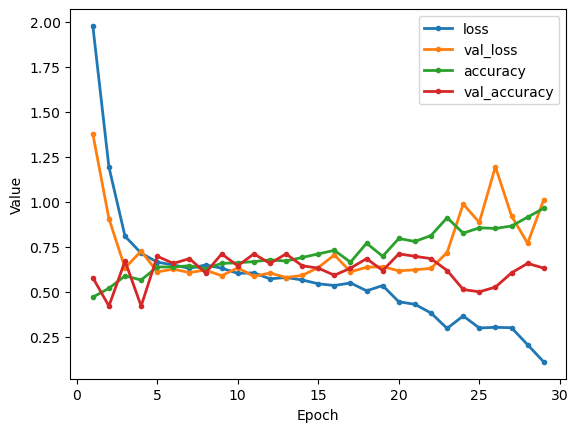

In [20]:
name="DNA_SNT_FEEDFORWARD1"
def feedforward_net1(name=name, num_output=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(850, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.1 MODEL 1-1 : FEED-FORWARD NETWORKS WITH EMBEDDINGS

Model: "DNA_SNT_FEEDFORWARD2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 97350)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 250)            │    24,337,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,338,251 (92.84 MB)

 Trainable params: 24,338,251 (92.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5621 - loss: 2.5922 - val_accuracy: 0.4211 - val_loss: 1.0914
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7087 - loss: 0.6270 - val_accuracy: 0.7500 - val_loss: 1.0369
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.8154 - loss: 0.4236 - val_accuracy: 0.7237 - val_loss: 0.9636
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.9530 - loss: 0.1564 - val_accuracy: 0.6579 - val_loss: 0.7046
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.9917 - loss: 0.0651 - val_accuracy: 0.6447 - val_loss: 0.9379
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.7105 - val_loss: 1.1116
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.7237 - val_loss: 1.5800
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9935 - loss: 0.0116 - val_accuracy: 0.7105 - v

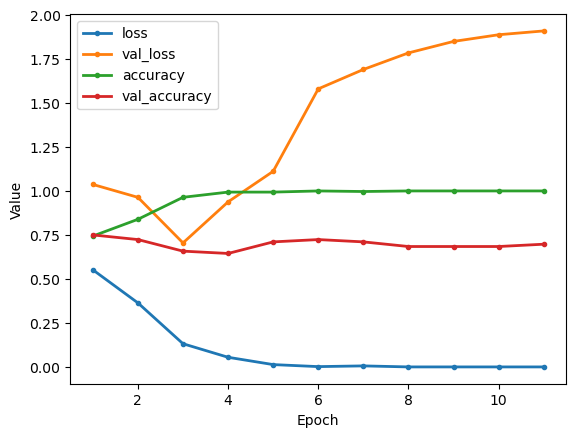

In [21]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_FEEDFORWARD2"
def feedforward_net2(name=name, num_output=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net2()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.2 MODEL 2 : CONVOLUTIONAL NEURAL NETWORKS (CNN)
DNA sequence can be thought of as 1-dimensional sequence (a single, long vector) and we can apply 1D Convolutions.

Model: "DNA_SNT_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1947, 200)      │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1945, 32)       │        19,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1944, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1942, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1941, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1941, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1941, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,761 (104.54 KB)

 Trainable params: 26,633 (104.04 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.4583 - loss: 0.6774 - val_accuracy: 0.6579 - val_loss: 0.6783
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.6301 - loss: 0.6160 - val_accuracy: 0.6579 - val_loss: 0.6697
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.7377 - loss: 0.5753 - val_accuracy: 0.6579 - val_loss: 0.6604
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.7654 - loss: 0.5441 - val_accuracy: 0.6711 - val_loss: 0.6526
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.7824 - loss: 0.5171 - val_accuracy: 0.6711 - val_loss: 0.6430
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.7629 - loss: 0.5410 - val_accuracy: 0.6842 - val_loss: 0.6401
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.7708 - loss: 0.5304 - val_accuracy: 0.6711 - val_loss: 0.6337
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.8166 - loss: 0.5030 - val_accuracy: 0.6711 - v

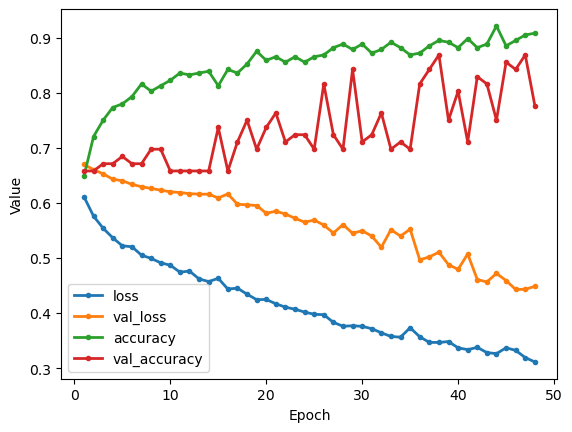

In [22]:
embedding_dim   = 200
vocabulary_size = 4+1
name="DNA_SNT_CNN"
def cnn(name=name, layers=2, filters=[32, 64, 100], num_output=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))

    for i in range(layers):
        model.add(Conv1D(filters=filters[i], kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(Dropout(0.1))

    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(num_output, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn(layers=2)
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.3 MODEL 3 : Simple RNN
At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

Model: "DNA_SNT_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 200)            │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,651 (197.86 KB)

 Trainable params: 50,651 (197.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.5119 - loss: 0.7031 - val_accuracy: 0.5526 - val_loss: 0.7212
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.5171 - loss: 0.7159 - val_accuracy: 0.4737 - val_loss: 0.7536
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.5329 - loss: 0.6987 - val_accuracy: 0.5263 - val_loss: 0.7152
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.5931 - loss: 0.6886 - val_accuracy: 0.5526 - val_loss: 0.6900
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5538 - loss: 0.7019 - val_accuracy: 0.5395 - val_loss: 0.6765
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.5600 - loss: 0.7003 - val_accuracy: 0.5000 - val_loss: 0.7367
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.4971 - loss: 0.7601 - val_accuracy: 0.5658 - val_loss: 0.6942
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5496 - loss: 0.6857 - val_accuracy: 0.4211 - val_loss: 0.7133


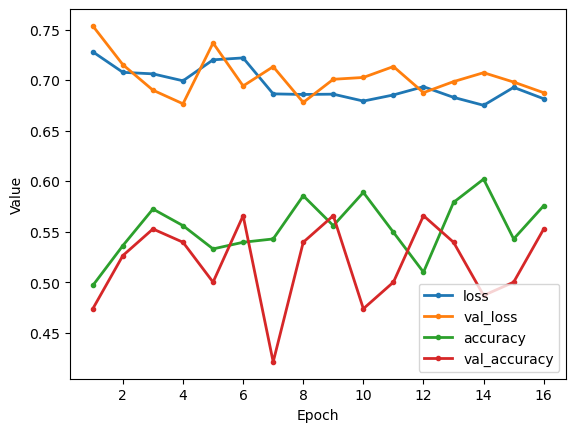

In [23]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_RNN"
def rnn(name=name, num_class=NUM_CLASS):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(SimpleRNN(200))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())
    model.add(Dense(num_class, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = rnn()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.4 MODEL 4 : LSTM
Now, let's use an LSTM model to do classification! To make it a fair comparison to the SimpleRNN, let's start with the same architecture hyper-parameters (e.g., number of hidden nodes, epochs, and batch size). Then, let's experiment with increasing the number of nodes, stacking multiple layers, applying dropouts etc.

Model: "DNA_SNT_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       200,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,251 (786.14 KB)

 Trainable params: 201,251 (786.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5814 - loss: 0.6904 - val_accuracy: 0.5789 - val_loss: 0.6782
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5703 - loss: 0.6834 - val_accuracy: 0.5789 - val_loss: 0.6775
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6038 - loss: 0.6747 - val_accuracy: 0.5789 - val_loss: 0.6804
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5554 - loss: 0.6869 - val_accuracy: 0.5789 - val_loss: 0.6845
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5562 - loss: 0.6846 - val_accuracy: 0.5789 - val_loss: 0.6839
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.5871 - loss: 0.6782 - val_accuracy: 0.5789 - val_loss: 0.6808
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.5714 - loss: 0.6785 - val_accuracy: 0.5789 - val_loss: 0.6782
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5710 - loss: 0.6766 - val_accuracy: 0.5789 - val_loss: 0.6758


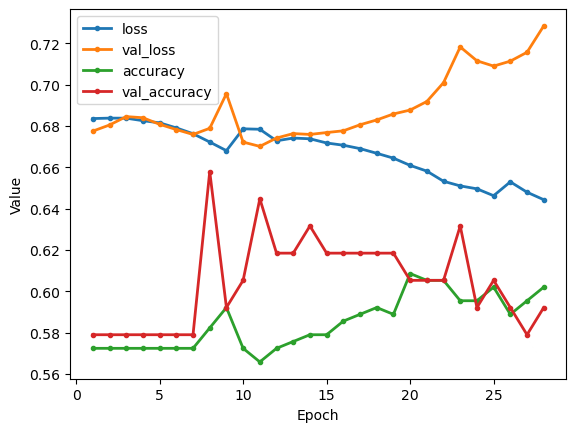

In [24]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_LSTM"
def sltm():
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(LSTM(200))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = sltm()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.4 MODEL 5 : CNN + LSTM
CNNs are good at learning spatial features, and sentences can be thought of as 1-D spatial vectors (dimensionality is determined by the number of words in the sentence). We apply an LSTM over the features learned by the CNN (after a maxpooling layer). This leverages the power of CNNs and LSTMs combined! We expect the CNN to be able to pick out invariant features across the 1-D spatial structure (i.e., sentence) that characterize 1 and 0 classes. This learned spatial features may then be learned as sequences by an LSTM layer, and the final classification can be made via a feed-forward connection to a single node.

Model: "DNA_SNT_CNNL_STM1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 1947, 50)       │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1947, 32)       │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 973, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500)            │     1,066,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,071,583 (4.09 MB)

 Trainable params: 1,071,583 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.5638 - loss: 0.6912 - val_accuracy: 0.5789 - val_loss: 0.6830
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.5545 - loss: 0.6874 - val_accuracy: 0.5789 - val_loss: 0.6865
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.5489 - loss: 0.6915 - val_accuracy: 0.5789 - val_loss: 0.6852
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5662 - loss: 0.6845 - val_accuracy: 0.5789 - val_loss: 0.6840
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.5502 - loss: 0.6873 - val_accuracy: 0.5789 - val_loss: 0.6832
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5912 - loss: 0.6820 - val_accuracy: 0.5789 - val_loss: 0.6830
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5736 - loss: 0.6793 - val_accuracy: 0.5789 - val_loss: 0.6830
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.5630 - loss: 0.6830 - val_accuracy: 0.5789 - val_loss: 0.682

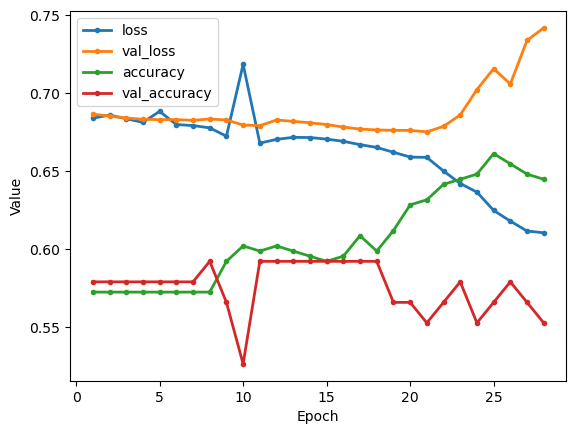

In [25]:
embedding_dim   = 50
vocabulary_size = 4+1
name="DNA_SNT_CNNL_STM1"
def cnn_lstm():
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(500))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn_lstm()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<div style="background-color: #80c4e6; padding: 0.5em;">
    <b>RECAP</b>: BEST MODEL FOUND
    
    * In general we are not satisfied with this approach
    
</div>